In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Quitar los casetones.
Quitar las plantas con muros de contención?

Cuanto más alto es el edificio, mayor es la carga en los muros y los pilares.
Los muros de contención suben mucho los kg y cuanto más profundo más kg/m2 de muro y por tanto más kg/m2 totales.

In [2]:
df = pd.read_csv('../data/split/train.csv', sep=';', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18969 entries, 0 to 22635
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   floor_name              18969 non-null  object 
 1   project_code            18969 non-null  object 
 2   floor_code              18969 non-null  object 
 3   slab_type               18969 non-null  object 
 4   depth                   18969 non-null  float64
 5   floor_number            18969 non-null  int64  
 6   total_height            18969 non-null  float64
 7   level                   18969 non-null  float64
 8   height                  18969 non-null  float64
 9   foundation_height       18969 non-null  float64
 10  support_column          18969 non-null  int64  
 11  unsupported_column      18969 non-null  int64  
 12  walls_number            18969 non-null  int64  
 13  retaining_walls_number  18969 non-null  int64  
 14  inter_axis_distance     18969 non-null

In [4]:
df['reinf_steel_total'] = df['reinf_steel_ratio'] * df['slab_total_area']
df['concrete_m3_total'] = df['concrete_m3_ratio'] * df['slab_total_area']

## Aggregar características de las plantas

In [5]:
agg_dict = {
    # General
    'foundation_type': 'last',
    'concrete_m3_total': 'sum',
    'concrete_code': 'last',
    'load_code': 'last',
    'wind_code': 'last',
    'seismic_code': 'last',
    # Alturas
    'floor_number': 'last', 
    'total_height': 'last', 
    'height': 'sum',
    'foundation_height': 'last',
    'double_height': 'sum',
    'triple_height': 'sum',
    # Soportes
    'support_column': 'sum',
    'unsupported_column': 'sum', 
    'walls_number': 'sum',
    'retaining_walls_number': 'sum',
    'support_area': 'sum',
    'walls_area': 'sum',
    'retaining_walls_area': 'sum', 
    # Cargas
    'LL': 'median', 
    'DL': 'median', 
    'LL_max': 'median',
    'DL_max': 'median', 
    'wind_load_x': 'median',
    'wind_load_y': 'median',
    'seismic_acc': 'median',
    # Forjados
    'slab_total_area': 'sum',
    'flat_slab_area': 'sum', 
    'waffle_slab_area': 'sum',
    'depth': 'median', 
    'drop_panel_area': 'sum', 
    'domes_area': 'sum',
    'domes_number': 'sum',
    'inter_axis_distance': 'last',
    # Forma
    'shape_factor': 'median',
    'x_length': 'median', 
    'y_length': 'median',
    'center_x': 'median',
    'center_y': 'median',
    'cdm_x': 'median',
    'cdm_y': 'median',
    'cdr_x': 'median',
    'cdr_y': 'median',
    # Objetivo
    'reinf_steel_total': 'sum',
}

In [6]:
b_df = df[['project_code']+list(agg_dict.keys())].groupby(by='project_code').agg(agg_dict)
b_df['reinf_steel_ratio'] = b_df['reinf_steel_total'] / b_df['slab_total_area']
b_df['concrete_m3_ratio'] = b_df['concrete_m3_total'] / b_df['slab_total_area']
del b_df['reinf_steel_total']
del b_df['concrete_m3_total']
b_df.reset_index(inplace=True)
# ori_cond = b_df['project_code'].str.contains('_C00_I00_H00_Q00_R00_V00_S00_O01')
# b_df = b_df[ori_cond].copy()
del b_df['project_code']

In [7]:
corr_matrix = b_df.select_dtypes(include=['float64']).corr()
corr_matrix["reinf_steel_ratio"].sort_values(ascending=False)[:10]

reinf_steel_ratio       1.000000
concrete_m3_ratio       0.516944
total_height            0.480227
height                  0.479151
walls_area              0.238914
support_area            0.232062
retaining_walls_area    0.184468
DL                      0.165128
LL_max                  0.143626
drop_panel_area         0.117846
Name: reinf_steel_ratio, dtype: float64

In [8]:
corr_matrix["reinf_steel_ratio"].sort_values(ascending=True)[:10]

x_length            -0.326055
shape_factor        -0.300806
y_length            -0.249681
foundation_height   -0.235096
cdr_y               -0.086871
center_y            -0.086461
cdm_y               -0.073267
flat_slab_area      -0.070369
cdm_x               -0.064210
center_x            -0.050735
Name: reinf_steel_ratio, dtype: float64

In [9]:
b_df['eccentricity'] = ((b_df['cdm_x'] - b_df['cdr_x'])*(b_df['cdm_x'] - b_df['cdr_x']) + 
                      (b_df['cdm_y'] - b_df['cdr_y']) * (b_df['cdm_y'] - b_df['cdr_y']))**0.5

In [10]:
b_df['eccentricity_b'] = ((b_df['cdm_x'] - b_df['center_x'])*(b_df['cdm_x'] - b_df['center_x']) + 
                      (b_df['cdm_y'] - b_df['center_y']) * (b_df['cdm_y'] - b_df['center_y']))**0.5

In [11]:
b_df['eccentricity_c'] = ((b_df['center_x'] - b_df['cdr_x'])*(b_df['center_x'] - b_df['cdr_x']) + 
                      (b_df['center_y'] - b_df['cdr_y']) * (b_df['center_y'] - b_df['cdr_y']))**0.5

In [12]:
corr_matrix = b_df[['eccentricity', 'eccentricity_b', 'eccentricity_c', "reinf_steel_ratio"]].corr()
corr_matrix["reinf_steel_ratio"].sort_values(ascending=False)[:10]

reinf_steel_ratio    1.000000
eccentricity         0.031834
eccentricity_b       0.030691
eccentricity_c      -0.063860
Name: reinf_steel_ratio, dtype: float64

## Modelo sin procesar características

### Preparando los datos

In [10]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor

In [11]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) 

### Entrenando el modelo

In [12]:
b_df.columns

Index(['foundation_type', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'double_height', 'triple_height', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'support_area', 'walls_area', 'retaining_walls_area', 'LL', 'DL',
       'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc',
       'slab_total_area', 'flat_slab_area', 'waffle_slab_area', 'depth',
       'drop_panel_area', 'domes_area', 'domes_number', 'inter_axis_distance',
       'shape_factor', 'x_length', 'y_length', 'center_x', 'center_y', 'cdm_x',
       'cdm_y', 'cdr_x', 'cdr_y', 'reinf_steel_ratio', 'concrete_m3_ratio',
       'eccentricity'],
      dtype='object')

In [13]:
b_df = b_df.drop(['center_x', 'center_y', 'cdm_x', 'cdm_y', 'cdr_x', 'cdr_y'], axis=1)

In [14]:
X = b_df.drop("reinf_steel_ratio", axis=1)
y = b_df["reinf_steel_ratio"].copy()

In [15]:
X.columns

Index(['foundation_type', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'double_height', 'triple_height', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'support_area', 'walls_area', 'retaining_walls_area', 'LL', 'DL',
       'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc',
       'slab_total_area', 'flat_slab_area', 'waffle_slab_area', 'depth',
       'drop_panel_area', 'domes_area', 'domes_number', 'inter_axis_distance',
       'shape_factor', 'x_length', 'y_length', 'concrete_m3_ratio',
       'eccentricity'],
      dtype='object')

#### Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

lin_reg = TransformedTargetRegressor(make_pipeline(preprocessing, LinearRegression()), transformer=StandardScaler())
# lin_reg_rmses = -cross_val_score(lin_reg, X, y, scoring="neg_root_mean_squared_error", cv=10)
lin_reg_mapes = cross_val_score(lin_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

In [17]:
pd.Series(lin_reg_mapes).describe()

count    1.000000e+01
mean     1.390405e+09
std      4.396848e+09
min      9.180133e-02
25%      1.079031e-01
50%      1.189385e-01
75%      1.394855e-01
max      1.390405e+10
dtype: float64

#### RandomForestRegressor

In [101]:
%%time
from sklearn.ensemble import RandomForestRegressor

# forest_reg = make_pipeline(preprocessing,
#                           RandomForestRegressor(random_state=42))
forest_reg = TransformedTargetRegressor(make_pipeline(preprocessing, RandomForestRegressor(random_state=42)), transformer=StandardScaler())
forest_reg_mapes = cross_val_score(forest_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 20.5 s, sys: 5.09 ms, total: 20.6 s
Wall time: 20.5 s


In [102]:
pd.Series(forest_reg_mapes).describe()

count    10.000000
mean      0.105819
std       0.014725
min       0.085567
25%       0.096205
50%       0.101149
75%       0.117513
max       0.129586
dtype: float64

In [66]:
forest_model = forest_reg.fit(X, y)

In [67]:
forest_model.named_steps

{'columntransformer': ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler())]),
                   transformers=[('cat',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f787a25e260>)]),
 'randomforestregressor': RandomForestRegressor(random_state=42)}

In [68]:
sorted(zip(forest_model['randomforestregressor'].feature_importances_, preprocessing.get_feature_names_out()), reverse=True)

[(0.2451354012111266, 'remainder__total_height'),
 (0.07068809048950607, 'remainder__slab_total_area_height'),
 (0.04911738518127803, 'remainder__concrete_m3_ratio'),
 (0.04388864580908026, 'remainder__support_area_m2'),
 (0.040554871380218724, 'remainder__height'),
 (0.038212372657004556, 'remainder__slab_area_mean'),
 (0.03629090086122097, 'remainder__wind_load_x'),
 (0.03388196140586034, 'remainder__total_load'),
 (0.030376351360040688, 'remainder__drop_panel_area_m2'),
 (0.027084217624919905, 'remainder__height_mean'),
 (0.024846939880225814, 'remainder__domes_area_m2'),
 (0.02120106092667191, 'cat__concrete_code_CBH-87'),
 (0.017979219056407605, 'remainder__wind_load_y'),
 (0.017269465651936752, 'remainder__eccentricity_b'),
 (0.016721149850081024, 'remainder__eccentricity_c'),
 (0.01621072909306345, 'remainder__x_length_m2'),
 (0.015812190709892582, 'remainder__LL_max'),
 (0.015646534265091966, 'remainder__support_column'),
 (0.014158984660223979, 'remainder__eccentricity_m2'),
 

#### Histogram-Based Gradient Boosting

In [18]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654 entries, 0 to 1653
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   foundation_type         1654 non-null   object 
 1   concrete_code           1654 non-null   object 
 2   load_code               1654 non-null   object 
 3   wind_code               1654 non-null   object 
 4   seismic_code            1654 non-null   object 
 5   floor_number            1654 non-null   int64  
 6   total_height            1654 non-null   float64
 7   height                  1654 non-null   float64
 8   foundation_height       1654 non-null   float64
 9   double_height           1654 non-null   float64
 10  triple_height           1654 non-null   float64
 11  support_column          1654 non-null   int64  
 12  unsupported_column      1654 non-null   int64  
 13  walls_number            1654 non-null   int64  
 14  retaining_walls_number  1654 non-null   

In [31]:
X.loc[:, cat_names] = X.loc[:, cat_names].astype('category')

/tmp/ipykernel_8250/2901458512.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, cat_names] = X.loc[:, cat_names].astype('category')


In [39]:
%%time
# hgbr_reg = make_pipeline(preprocessing, 
#                            HistGradientBoostingRegressor(random_state=42))
# hgbr_reg = TransformedTargetRegressor(hgbr_reg, transformer=StandardScaler())
# cat_names = ['foundation_type', 'concrete_code', 'load_code', 'wind_code', 'seismic_code']
cat_names = [0, 1, 2, 3, 4]
hgbr_reg = HistGradientBoostingRegressor(categorical_features=cat_names, random_state=42)
hgbr_reg_mapes = cross_val_score(hgbr_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 361, in fit
    X, y = self._validate_data(X, y, dtype=[X_DTYPE], force_all_finite=False)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/base.py", line 554, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1104, in check_X_y
    X = check_array(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/validation.py", line 877, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'GROUNDSLAB'

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 361, in fit
    X, y = self._validate_data(X, y, dtype=[X_DTYPE], force_all_finite=False)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/base.py", line 554, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1104, in check_X_y
    X = check_array(
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/validation.py", line 877, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'FOOTING'


In [104]:
pd.Series(hgbr_reg_mapes).describe()

count    10.000000
mean      0.093372
std       0.009290
min       0.077375
25%       0.088488
50%       0.092711
75%       0.095837
max       0.112043
dtype: float64

### SVR 

In [72]:
from sklearn.svm import SVR

In [105]:
%%time
svr = make_pipeline(preprocessing, SVR())
svr = TransformedTargetRegressor(svr, transformer=StandardScaler())
svr_mapes = cross_val_score(svr, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.02 s


In [106]:
pd.Series(svr_mapes).describe()

count    10.000000
mean      0.097938
std       0.016114
min       0.077517
25%       0.087404
50%       0.093448
75%       0.106289
max       0.129760
dtype: float64

In [107]:
%%time
svr_rbf = make_pipeline(preprocessing, SVR(kernel="rbf"))
svr_rbf = TransformedTargetRegressor(svr_rbf, transformer=StandardScaler())
svr_rbf_mapes = cross_val_score(svr_rbf, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 1.03 s, sys: 1.45 ms, total: 1.03 s
Wall time: 1.03 s


In [108]:
pd.Series(svr_mapes).describe()

count    10.000000
mean      0.097938
std       0.016114
min       0.077517
25%       0.087404
50%       0.093448
75%       0.106289
max       0.129760
dtype: float64

In [109]:
%%time
svr_poly4 = make_pipeline(preprocessing, SVR(kernel="poly", degree=2))
svr_poly4 = TransformedTargetRegressor(svr_poly4, transformer=StandardScaler())
svr_poly4_mapes = cross_val_score(svr_poly4, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


In [110]:
pd.Series(svr_poly4_mapes).describe()

count    10.000000
mean      0.113133
std       0.016374
min       0.090269
25%       0.106779
50%       0.109106
75%       0.112850
max       0.146001
dtype: float64

### Red neuronal

In [80]:
from sklearn.neural_network import MLPRegressor

In [111]:
%%time
nn = make_pipeline(preprocessing, MLPRegressor(hidden_layer_sizes=(100, 50, 20), early_stopping=True, learning_rate='invscaling', random_state=43, max_iter=1000))
nn = TransformedTargetRegressor(nn, transformer=StandardScaler())
nn_mapes = cross_val_score(nn, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 22.3 s, sys: 48.8 s, total: 1min 11s
Wall time: 4.48 s


In [112]:
pd.Series(nn_mapes).describe()

count    10.000000
mean      0.106683
std       0.018611
min       0.085528
25%       0.096386
50%       0.100123
75%       0.115094
max       0.144703
dtype: float64

In [36]:
df['LL_total'] = df['LL'] * df['slab_total_area']
df['DL_total'] = df['DL'] * df['slab_total_area']
df['LL_max_total'] = df['LL_max'] * df['slab_total_area']
df['DL_max_total'] = df['DL_max'] * df['slab_total_area']
df['wind_load_x_total'] = df['wind_load_x'] * df['slab_total_area']
df['wind_load_y_total'] = df['wind_load_y'] * df['slab_total_area']
df['seismic_acc_total'] = df['seismic_acc'] * df['slab_total_area']

In [6]:
df.columns

Index(['floor_name', 'project_code', 'floor_code', 'slab_type', 'depth',
       'floor_number', 'total_height', 'level', 'height', 'foundation_height',
       'support_column', 'unsupported_column', 'walls_number',
       'retaining_walls_number', 'inter_axis_distance', 'LL', 'DL', 'LL_max',
       'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc', 'double_height',
       'flat_slab_area', 'waffle_slab_area', 'drop_panel_area', 'domes_area',
       'support_area', 'shape_factor', 'x_length', 'y_length', 'stair_area',
       'slope_area', 'walls_area', 'retaining_walls_area', 'foundation_type',
       'concrete_m3_ratio', 'reinf_steel_ratio', 'domes_number',
       'deflection_ratio', 'elasticiti_modulii', 'cdm_x', 'cdm_y', 'cdr_x',
       'cdr_y', 'concrete_code', 'load_code', 'wind_code', 'seismic_code',
       'support_mean_span_dist', 'support_max_span_dist',
       'support_min_span_dist', 'cantilever_mean_dist', 'cantilever_max_dist',
       'cantilever_min_dist', 'cantilever_

## depth

In [7]:
df['flat_depth'] = 0
df.loc[df['slab_type'] == 'FLAT_SLAB', 'flat_depth'] = df.loc[df['slab_type'] == 'FLAT_SLAB', 'depth']
df['waffle_depth'] = 0
df.loc[df['slab_type'] == 'FOAM_WAFFLE', 'waffle_depth'] = df.loc[df['slab_type'] == 'FOAM_WAFFLE', 'depth']

## cdm y cdr

In [8]:
df['eccentricity'] = ((df['cdm_x'] - df['cdr_x'])*(df['cdm_x'] - df['cdr_x']) + 
                      (df['cdm_y'] - df['cdr_y']) * (df['cdm_y'] - df['cdr_y']))**0.5
df['weighted_eccentricity'] = df['eccentricity'] * df['slab_total_area']

## max_length

In [9]:
df['max_length'] = df[['x_length', 'y_length']].max(axis=1)

## Aggregar características de las plantas

In [ ]:
agg_dict = {
    'floor_number': 'last', 
    'total_height': 'last', 
    'height': 'sum',
    'foundation_height': 'last',
    'support_column': 'sum',
    'unsupported_column': 'sum', 
    'walls_number': 'sum',
    'retaining_walls_number': 'sum',
    'inter_axis_distance': 'last', 
    'LL_total': 'sum', 
    'DL_total': 'sum', 
    'LL_max_total': 'sum',
    'DL_max_total': 'sum', 
    'wind_load_x_total': 'sum',
    'wind_load_y_total': 'sum',
    'seismic_acc_total': 'sum',
    'double_height': 'sum',
    'triple_height': 'sum',
    'flat_depth': 'max',
    'waffle_depth': 'max',
    'flat_slab_area': 'sum', 
    'waffle_slab_area': 'sum', 
    'drop_panel_area': 'sum', 
    'domes_area': 'sum',
    'support_area': 'sum',
    'shape_factor': 'mean',
    'x_length': 'median', 
    'y_length': 'median',
    'max_length': 'median',
    'walls_area': 'sum',
    'retaining_walls_area': 'sum',
    'foundation_type': 'last',
    'concrete_m3_total': 'sum',
    'domes_number': 'sum',
    'eccentricity': 'median',
    'weighted_eccentricity': 'sum',
    'concrete_code': 'last',
    'load_code': 'last',
    'wind_code': 'last',
    'seismic_code': 'last',
    'support_mean_span_dist': 'mean',
    'support_max_span_dist': 'mean',
    'support_min_span_dist': 'mean',
    'cantilever_mean_dist': 'mean',
    'cantilever_max_dist': 'mean',
    'cantilever_min_dist': 'mean',
    'cantilever_area': 'mean',
    'center_x': 'mean',
    'center_y': 'mean',
    'slab_total_area': 'sum',
    'reinf_steel_total': 'sum',
}

In [11]:
df[list(agg_dict.keys())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19113 entries, 0 to 22635
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   floor_number            19113 non-null  int64  
 1   total_height            19113 non-null  float64
 2   height                  19113 non-null  float64
 3   foundation_height       19113 non-null  float64
 4   support_column          19113 non-null  int64  
 5   unsupported_column      19113 non-null  int64  
 6   walls_number            19113 non-null  int64  
 7   retaining_walls_number  19113 non-null  int64  
 8   inter_axis_distance     19113 non-null  float64
 9   LL_total                19113 non-null  float64
 10  DL_total                19113 non-null  float64
 11  LL_max_total            19113 non-null  float64
 12  DL_max_total            19113 non-null  float64
 13  wind_load_x_total       19113 non-null  float64
 14  wind_load_y_total       19113 non-null

In [13]:
b_df = df[['project_code']+list(agg_dict.keys())].groupby(by='project_code').agg(agg_dict)
b_df['reinf_steel_ratio'] = b_df['reinf_steel_total'] / b_df['slab_total_area']
b_df['concrete_m3_ratio'] = b_df['concrete_m3_total'] / b_df['slab_total_area']
b_df['weighted_eccentricity'] /= b_df['slab_total_area']
del b_df['reinf_steel_total']
b_df.reset_index(inplace=True)

In [14]:
b_df.columns

Index(['project_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'support_column', 'unsupported_column',
       'walls_number', 'retaining_walls_number', 'inter_axis_distance',
       'LL_total', 'DL_total', 'LL_max_total', 'DL_max_total',
       'wind_load_x_total', 'wind_load_y_total', 'seismic_acc_total',
       'double_height', 'triple_height', 'flat_depth', 'waffle_depth',
       'flat_slab_area', 'waffle_slab_area', 'drop_panel_area', 'domes_area',
       'support_area', 'shape_factor', 'x_length', 'y_length', 'max_length',
       'walls_area', 'retaining_walls_area', 'foundation_type',
       'concrete_m3_total', 'domes_number', 'eccentricity',
       'weighted_eccentricity', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'support_mean_span_dist', 'support_max_span_dist',
       'support_min_span_dist', 'cantilever_mean_dist', 'cantilever_max_dist',
       'cantilever_min_dist', 'cantilever_area', 'center_x', 'center_y',
       'sla

In [39]:
b_df['height_mean'] = b_df['height'] / b_df['floor_number']

In [40]:
ori_cond = b_df['project_code'].str.contains('_C00_I00_H00_Q00_R00_V00_S00_O01')

KeyError: 'project_code'

## reinf_steel_ratio

<AxesSubplot: >

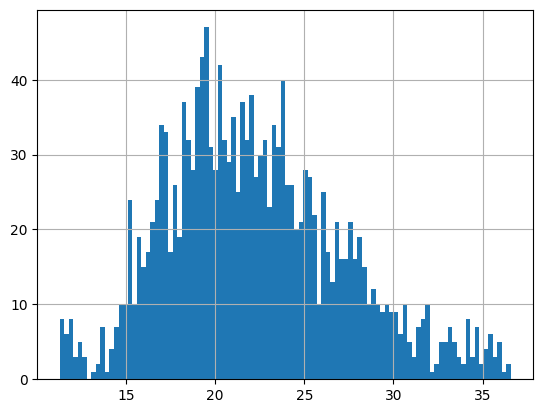

In [41]:
b_df['reinf_steel_ratio'].hist(bins=100)

<AxesSubplot: >

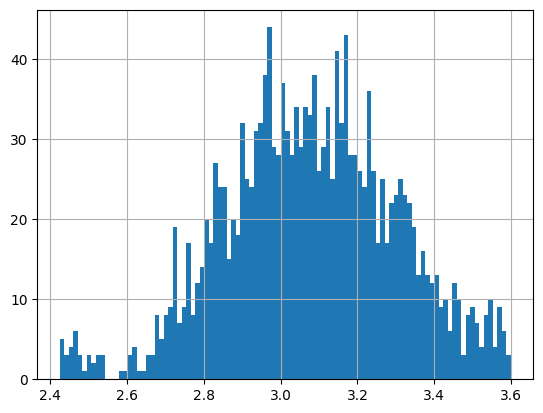

In [42]:
np.log(b_df['reinf_steel_ratio']).hist(bins=100)

In [43]:
b_df['slab_total_area_height'] = b_df['slab_total_area'] / b_df['height']

<AxesSubplot: xlabel='reinf_steel_ratio', ylabel='slab_total_area_height'>

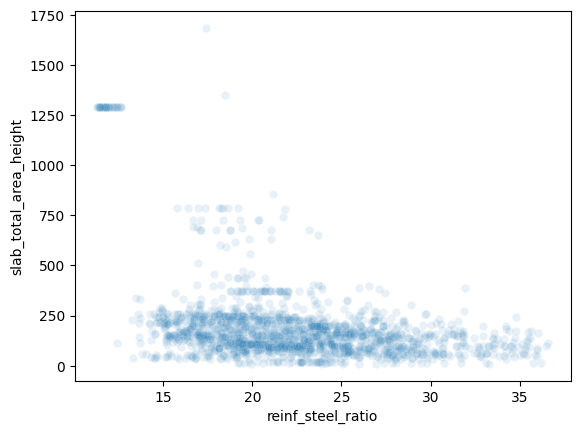

In [44]:
sns.scatterplot(data=b_df, x='reinf_steel_ratio', y='slab_total_area_height', alpha=0.1)

In [45]:
b_df[b_df['slab_total_area_height'] > 6000]

,foundation_type,concrete_code,load_code,wind_code,seismic_code,floor_number,total_height,height,foundation_height,double_height,...,y_length,reinf_steel_ratio,concrete_m3_ratio,eccentricity,eccentricity_b,eccentricity_c,max_length,eccentricity_length,height_mean,slab_total_area_height


In [46]:
df[df['project_code'] == 'BOSC17021_C00_I00_H00_Q00_R00_V00_S00_O01']

,floor_name,project_code,floor_code,slab_type,depth,floor_number,total_height,level,height,foundation_height,...,reinf_steel_ratio_cat,reinf_steel_total,concrete_m3_total,LL_total,DL_total,LL_max_total,DL_max_total,wind_load_x_total,wind_load_y_total,seismic_acc_total
8459,SS1,BOSC17021_C00_I00_H00_Q00_R00_V00_S00_O01,BOSC17021_C00_I00_H00_Q00_R00_V00_S00_O01_F0,FOAM_WAFFLE,0.35,2,0.85,-2.65,4.35,-7.0,...,LIGHT-MED,66845.166223,642.592585,12220.322893,3055.080723,12220.322893,97762.583142,0.000000,0.000000,464.372270
8460,PB,BOSC17021_C00_I00_H00_Q00_R00_V00_S00_O01,BOSC17021_C00_I00_H00_Q00_R00_V00_S00_O01_F1,FOAM_WAFFLE,0.35,2,0.85,0.85,3.50,-7.0,...,LIGHT-MED,67353.850717,588.707964,15490.766034,9294.459621,15490.766034,55766.757723,155626.431886,54056.577153,470.919287


In [47]:
corr_matrix = b_df.select_dtypes(include=['float64']).corr()
corr_matrix["reinf_steel_ratio"].sort_values(ascending=False)

reinf_steel_ratio         1.000000
concrete_m3_ratio         0.516944
total_height              0.480227
height                    0.479151
walls_area                0.238914
support_area              0.232062
height_mean               0.216949
retaining_walls_area      0.184468
DL                        0.165128
LL_max                    0.143626
drop_panel_area           0.117846
triple_height             0.082289
inter_axis_distance       0.081387
DL_max                    0.072597
wind_load_x               0.071952
LL                        0.068779
eccentricity_length       0.065597
eccentricity              0.031834
eccentricity_b            0.030691
waffle_slab_area          0.026875
slab_total_area           0.025713
double_height             0.015208
depth                     0.006800
domes_area               -0.001115
seismic_acc              -0.021723
wind_load_y              -0.032243
eccentricity_c           -0.063860
flat_slab_area           -0.070369
foundation_height   

In [48]:
b_df['LL'] = b_df['LL_total'] * b_df['slab_total_area']
b_df['DL'] = b_df['DL_total'] * b_df['slab_total_area']
b_df['LL_max'] = b_df['LL_max_total'] * b_df['slab_total_area']
b_df['DL_max'] = b_df['DL_max_total'] * b_df['slab_total_area']
b_df['wind_load_x'] = b_df['wind_load_x_total'] * b_df['slab_total_area']
b_df['wind_load_y'] = b_df['wind_load_y_total'] * b_df['slab_total_area']
b_df['seismic_acc'] = b_df['seismic_acc_total'] * b_df['slab_total_area']

KeyError: 'LL_total'

In [49]:
b_df['total_load'] = b_df['LL'] + b_df['DL'] + b_df['wind_load_x'] + b_df['wind_load_y'] + b_df['seismic_acc']

In [50]:
b_df['flat_slab_area_m2'] = b_df['flat_slab_area'] / b_df['slab_total_area'] 
b_df['waffle_slab_area_m2'] = b_df['waffle_slab_area'] / b_df['slab_total_area'] 
b_df['drop_panel_area_m2'] = b_df['drop_panel_area'] / b_df['slab_total_area'] 
b_df['domes_area_m2'] = b_df['domes_area'] / b_df['slab_total_area'] 
b_df['support_area_m2'] = b_df['support_area'] / b_df['slab_total_area'] 
b_df['walls_area_m2'] = b_df['walls_area'] / b_df['slab_total_area']
b_df['retaining_walls_area_m2'] = b_df['retaining_walls_area'] / b_df['slab_total_area'] 

In [52]:
b_df['walls_area_m2'] = b_df['walls_area'] / b_df['slab_total_area']

In [53]:
b_df['slab_area_mean'] = b_df['slab_total_area'] / b_df['floor_number']

In [54]:
b_df['x_length_m2'] = b_df['x_length'] / b_df['slab_area_mean']

In [55]:
b_df['underground_height'] = (b_df['height'] - b_df['total_height']) / b_df['height']

In [56]:
corr_matrix = b_df.select_dtypes(include=['float64']).corr()
corr_matrix["reinf_steel_ratio"].sort_values(ascending=False)['underground_height']

-0.05678998819085872

## Eccentricity

Según los expertos, la escentricidad es un factor muy importante para determinar los kg de acero por m2. Sin embargo, vemos que no está nada correlacionado. Esto indica que todavía debe haber datos erroneos.

In [57]:
b_df['max_length'] = b_df[['x_length', 'y_length']].max(axis=1)

In [58]:
b_df['eccentricity_length'] = b_df['eccentricity'] / b_df['max_length']
b_df['eccentricity_m2'] = b_df['eccentricity'] / b_df['slab_area_mean']
b_df['eccentricity_perimeter'] = b_df['eccentricity'] / b_df['shape_factor']

In [59]:
b_df['weighted_eccentricity_length'] = b_df['weighted_eccentricity'] / b_df['max_length']
b_df['weighted_eccentricity_m2'] = b_df['weighted_eccentricity'] / b_df['slab_area_mean']
b_df['weighted_eccentricity_perimeter'] = b_df['weighted_eccentricity'] / b_df['shape_factor']

KeyError: 'weighted_eccentricity'

<AxesSubplot: >

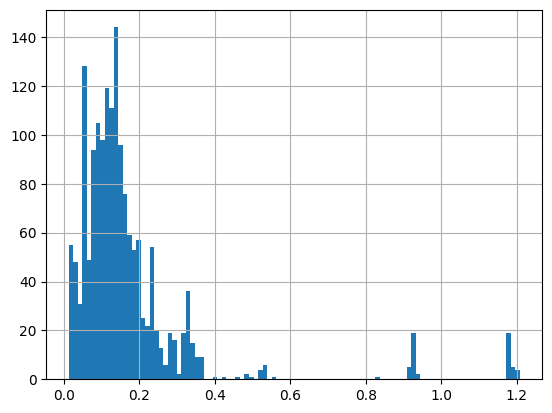

In [41]:
b_df['weighted_eccentricity_length'].hist(bins=100)

In [45]:
corr_matrix = b_df[(b_df['eccentricity_length'] < 0.3) & (b_df['total_height'] > 30)].select_dtypes(include=['float64']).corr()
corr_matrix["reinf_steel_ratio"].sort_values(ascending=False)['weighted_eccentricity_length']

-0.029890019729422155

In [183]:
b_df[b_df['eccentricity_length'] > 0.3]['project_code'].unique()

array(['BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP16004M3_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP17014M2_C03_I03_H01_Q02_R01_V08_S03_O01',
       'BOLP17014M2_C04_I01_H02_Q01_R01_V09_S04_O01',
       'BOLP17014M2_C07_I01_H05_Q02_R04_V01_S07_O01',
       'BOLP17014M2_C08_I02_H06_Q01_R03_V02_S08_O01',
       'BOLP17014M2_C09_I03_H07_Q02_R04_V03_S09_O01',
       'BOLP17014M2_C10_I01_H08_Q01_R04_V04_S10_O01',
       'BOLP17014M2_C11_I02_H09_Q02_R04_V05_S04_O01',
       'BOLP18425_C06_I03_H13_Q05_R04_V12_S05_O01',
       'BOLP18425_C07_I01_H14_Q05_R04_V12_S05_O01',
       'BOLP18425_C08_I02_H15_Q03_R09_V12_S05_O01',
       'BOLP18425_C09_I03_H04_Q04_R01_V12_S05_O01',
       'BOLP18425_C10_I01_H03_Q02_R04_V04_S05_O01',
       'BOLP18425_C11_I02_H09_Q07_R04_V12_S05_O01',
       'BOLP19008_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP19313_C01_I02_H00_Q01_R04_V12_S11_O02',
       'BOLP19313_C02_I02_H00_Q01_R04_V12_S11_O0

In [180]:
df[df['project_code'] == 'BOLP20403M1_C01_I03_H02_Q05_R04_V12_S03_O01'][['floor_name', 'slab_total_area', 'center_x', 'center_y', 'x_length', 'y_length', 'cdm_x', 'cdm_y', 'cdr_x', 'cdr_y']]

,floor_name,slab_total_area,center_x,center_y,x_length,y_length,cdm_x,cdm_y,cdr_x,cdr_y
5909,PISO 1,314.525605,13.187000,45.474721,18.000000,19.553442,25.349589,32.028368,12.846321,43.548582
5910,PISO 2,301.057095,13.187000,45.474721,18.000000,19.553442,26.629462,33.064593,12.508208,44.036909
5911,PIISO 3,301.057095,13.187000,45.474721,18.000000,19.553442,27.121433,32.760622,12.278273,44.043557
5912,PISO 4,302.845504,13.187000,45.474721,18.000000,19.553442,27.645695,32.721817,11.954423,44.384170
5913,PISO 5,182.724045,12.841836,45.060907,12.130328,16.725813,27.848607,33.150665,11.228990,44.940903
5914,PISO 6,182.724045,12.841836,45.060907,12.130328,16.725813,27.867681,33.133393,11.263363,44.926599
5915,PISO 7,182.724045,12.841836,45.060907,12.130328,16.725813,27.902785,33.102481,11.250353,44.895011
5916,PISO 8,182.724045,12.841836,45.060907,12.130328,16.725813,27.902785,33.102481,11.250353,44.895011
5917,PISO 9,182.724045,12.841836,45.060907,12.130328,16.725813,27.919719,33.094713,11.247672,44.924099
5918,PISO 10,182.724045,12.841836,45.060907,12.130328,16.725813,27.919719,33.094713,11.247672,44.924099


<AxesSubplot: xlabel='eccentricity_length', ylabel='reinf_steel_ratio'>

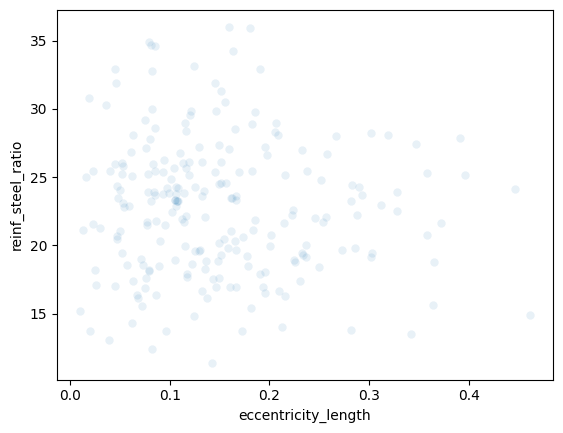

In [136]:
sns.scatterplot(data=b_df[ori_cond], x='eccentricity_length', y='reinf_steel_ratio', alpha=0.1)

In [137]:
fields = ['eccentricity', 'eccentricity_length', 'eccentricity_m2', 'eccentricity_perimeter', 'reinf_steel_ratio']
ecc_cm = b_df[fields].corr()
ecc_cm["reinf_steel_ratio"].sort_values(ascending=False)

reinf_steel_ratio         1.000000
eccentricity_m2           0.099036
eccentricity_length      -0.010011
eccentricity_perimeter   -0.040812
eccentricity             -0.162595
Name: reinf_steel_ratio, dtype: float64

<AxesSubplot: xlabel='eccentricity_m2', ylabel='reinf_steel_ratio'>

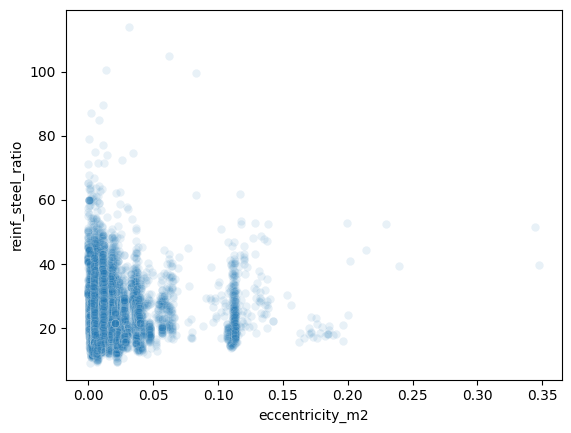

In [138]:
sns.scatterplot(data=df, x='eccentricity_m2', y='reinf_steel_ratio', alpha=0.1)

In [161]:

df['eccentricity_length'] = df['eccentricity'] / df['max_length']
df['eccentricity_m2'] = df['eccentricity'] / df['slab_total_area']
df['eccentricity_perimeter'] = df['eccentricity'] / df['shape_factor']
df['eccentricity_level'] = df['eccentricity'] / df['slab_total_area']

In [162]:
fields = ['eccentricity', 'eccentricity_length', 'eccentricity_m2', 
          'eccentricity_perimeter', 'eccentricity_level', 'reinf_steel_ratio']
cond = (
    (df['slab_type'] == 'FOAM_WAFFLE') &
    df['project_code'].str.contains('_C00_I00_H00_Q00_R00_V00_S00_O01') &
    (df['double_height'] == 0) &
    (df['triple_height'] == 0)
)
ecc_cm = df[cond][fields].corr()
ecc_cm["reinf_steel_ratio"].sort_values(ascending=False)

reinf_steel_ratio         1.000000
eccentricity_m2           0.028469
eccentricity_level        0.028469
eccentricity_perimeter   -0.030534
eccentricity_length      -0.047254
eccentricity             -0.061144
Name: reinf_steel_ratio, dtype: float64

<AxesSubplot: xlabel='eccentricity_m2', ylabel='reinf_steel_ratio'>

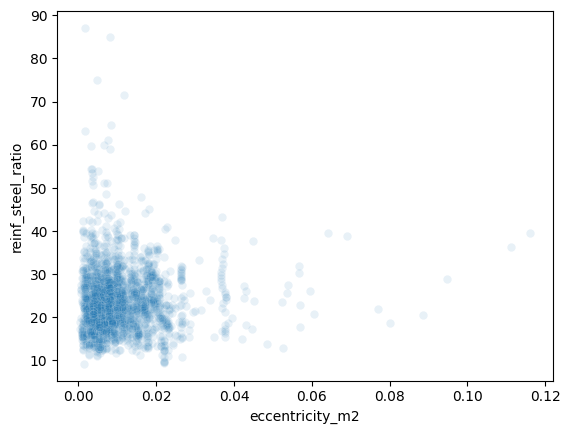

In [163]:
sns.scatterplot(data=df[cond], x='eccentricity_m2', y='reinf_steel_ratio', alpha=0.1)

In [106]:
X = b_df.drop("reinf_steel_ratio", axis=1)
y = b_df["reinf_steel_ratio"].copy()

In [90]:
import sklearn

In [91]:
sklearn.set_config(display="diagram")

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) 